MAE（平均絶対誤差）: 112.59666666666664


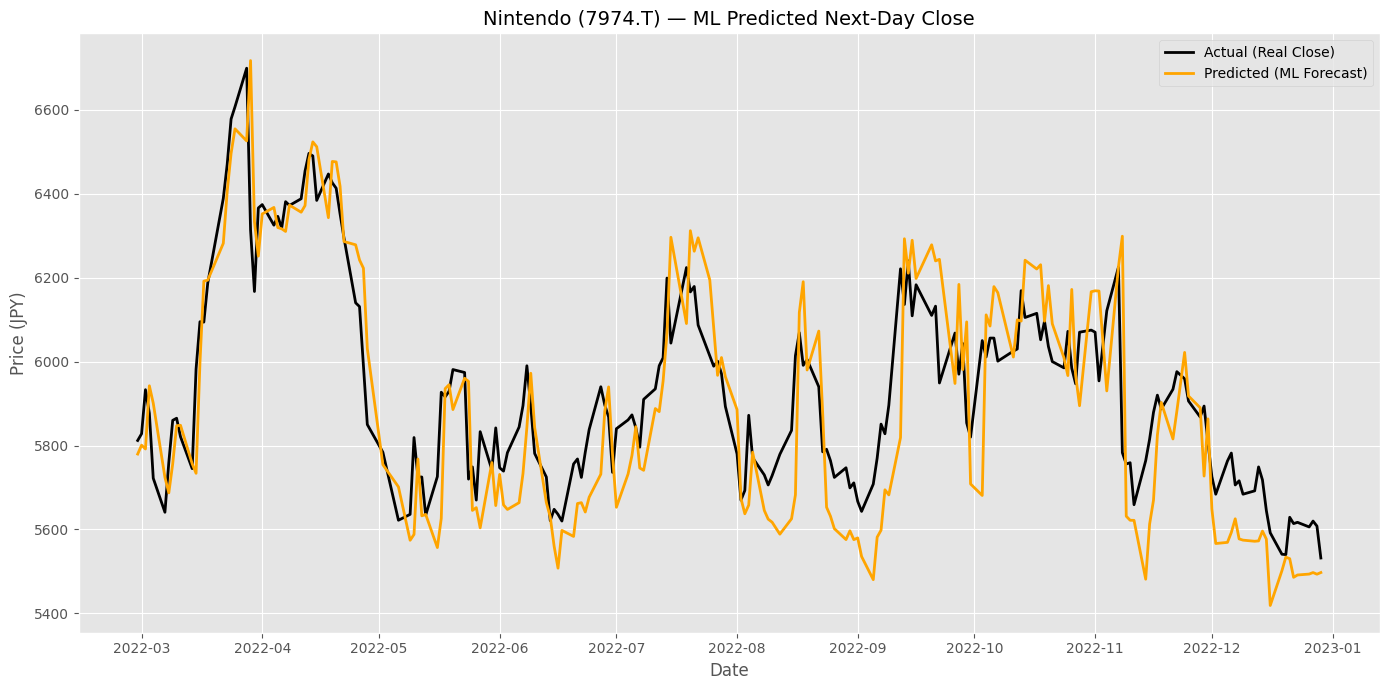

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# ============================================
# 1. SQLite からデータを読み込む
# ============================================
conn = sqlite3.connect("nintendo.db")

df = pd.read_sql("""
    SELECT Date, Close, MA20, MA50, MA200, Volume
    FROM nintendo
    ORDER BY Date;
""", conn)

conn.close()

df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")

# ============================================
# 2. 目的変数：翌日の Close（Target）
# ============================================
df["Target"] = df["Close"].shift(-1)
df = df.dropna()

# ============================================
# 3. 特徴量・目的変数
# ============================================
X = df[["Close", "MA20", "MA50", "MA200", "Volume"]]
y = df["Target"]

# ============================================
# 4. データ分割（最後20%をテスト）
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ============================================
# 5. モデル学習（Random Forest）
# ============================================
model = RandomForestRegressor(n_estimators=300, random_state=0)
model.fit(X_train, y_train)

# ============================================
# 6. 予測
# ============================================
y_pred = model.predict(X_test)

# ============================================
# 7. 誤差確認
# ============================================
mae = mean_absolute_error(y_test, y_pred)
print("MAE（平均絶対誤差）:", mae)

# ============================================
# 8. 可視化用データ
# ============================================
plot_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})
plot_df.index = y_test.index  # 日付を揃える

# ============================================
# 9. グラフ描画（実測値 vs 予測値）
# ============================================
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(plot_df.index, plot_df["Actual"], label="Actual (Real Close)", linewidth=2, color="black")
ax.plot(plot_df.index, plot_df["Predicted"], label="Predicted (ML Forecast)", linewidth=2, color="orange")

ax.set_title("Nintendo (7974.T) — ML Predicted Next-Day Close", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Price (JPY)")
ax.legend()

plt.tight_layout()
plt.show()


売りサインの日数： 138
            Actual    Predicted  SellSignal
Date                                       
2022-03-01  5828.0  5800.823333        True
2022-03-02  5933.0  5791.740000        True
2022-03-09  5860.0  5756.533333        True
2022-03-10  5865.0  5847.086667        True
2022-03-11  5821.0  5848.243333        True


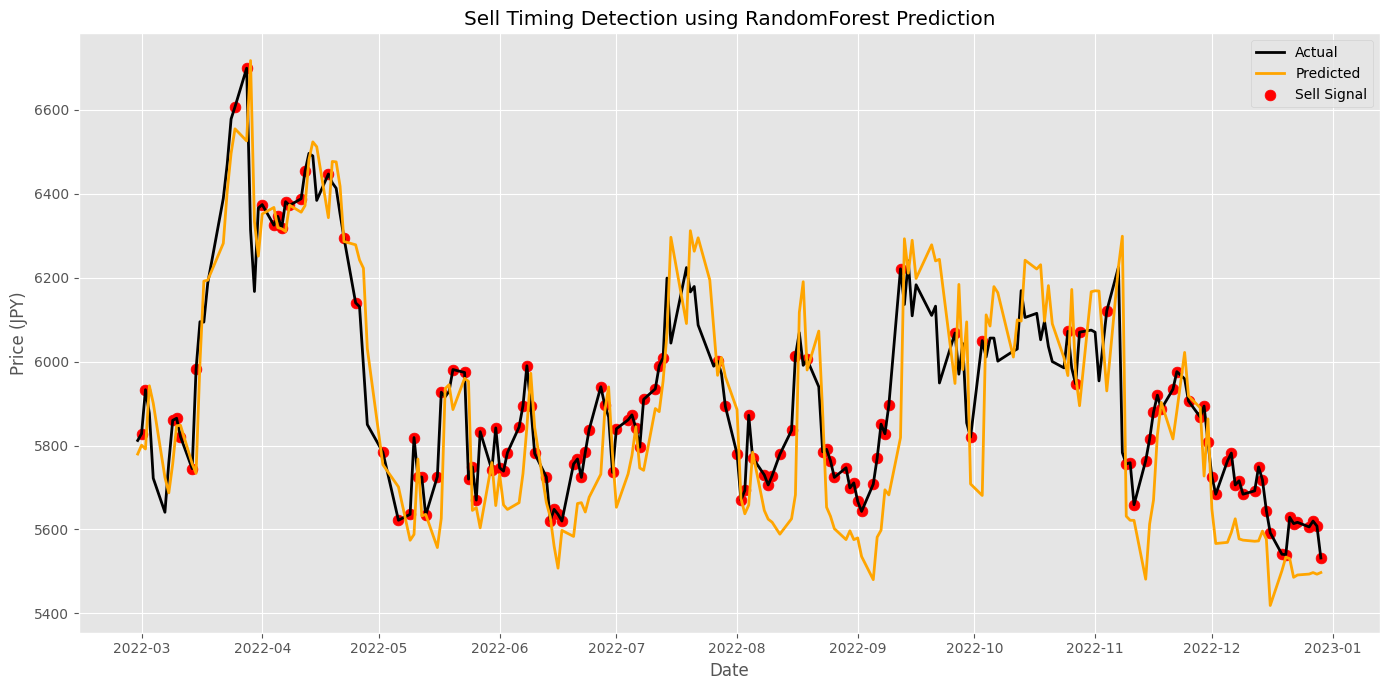

In [2]:
# plot_df: ActualとPredictedをまとめたDataFrame（前回のコードで生成済み）
import matplotlib.pyplot as plt

# 売りシグナル（予測下降）
plot_df["SellSignal"] = plot_df["Predicted"] < plot_df["Actual"].shift(1)

# 売りタイミングの抽出
sell_points = plot_df[plot_df["SellSignal"]]

print("売りサインの日数：", len(sell_points))
print(sell_points.head())

# ===== プロット =====
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14, 7))

# 実測値と予測値
ax.plot(plot_df.index, plot_df["Actual"], label="Actual", linewidth=2, color="black")
ax.plot(plot_df.index, plot_df["Predicted"], label="Predicted", linewidth=2, color="orange")

# 売りシグナル（赤丸）
ax.scatter(sell_points.index, sell_points["Actual"], color="red", s=60, label="Sell Signal")

ax.set_title("Sell Timing Detection using RandomForest Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Price (JPY)")
ax.legend()

plt.tight_layout()
plt.show()
